  left image already exists
  right image already exists
   Size: 450x375 pixels
   Disparity range: -1.0 to 51.6 pixels
   Generated 104,760 3D points
   Saved: task2_pointcloud.ply
   Saved: task2_results.png


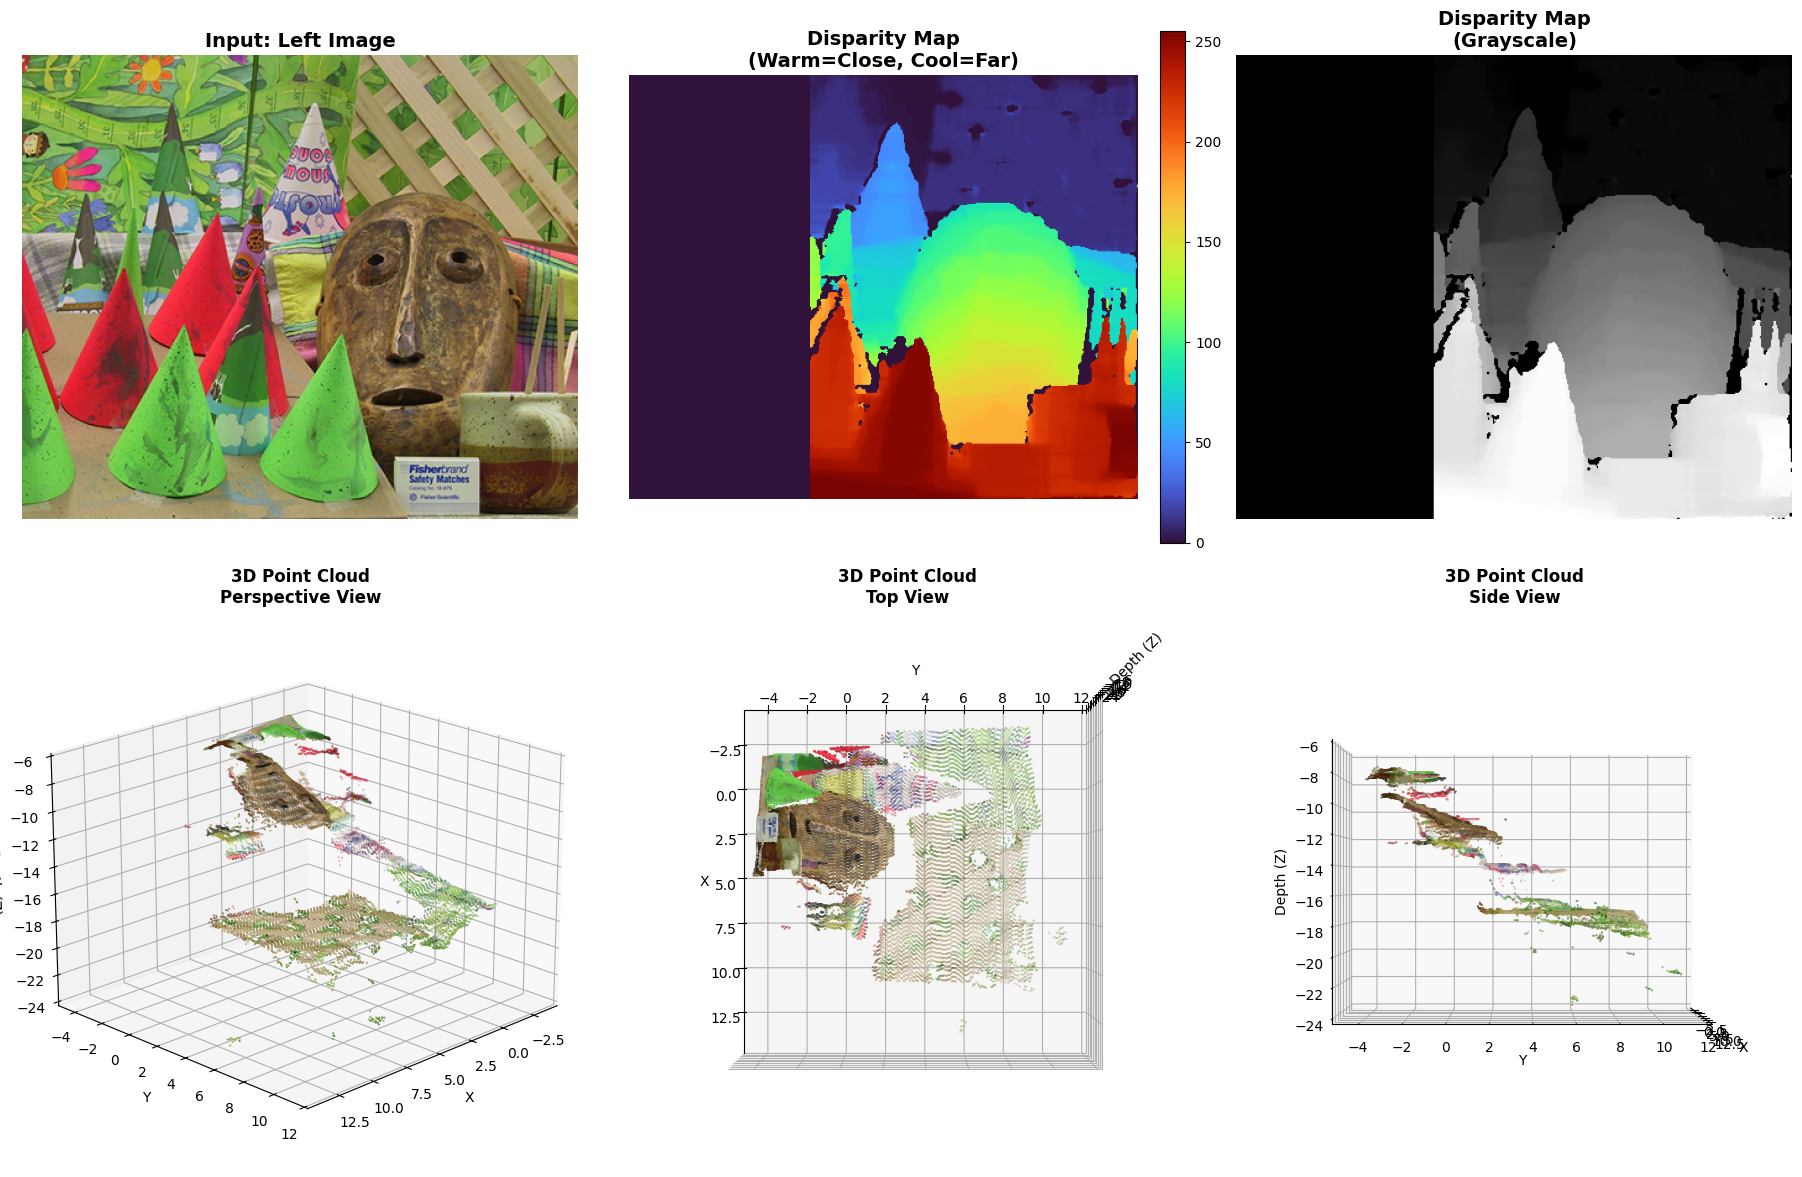

Processing Complete


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded


In [4]:
!pip install opencv-contrib-python matplotlib numpy -q

import os
import urllib.request

# Create directory
os.makedirs('middlebury_data/cones', exist_ok=True)

# Download images
urls = {
    'left': 'https://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im2.png',
    'right': 'https://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im6.png'
}

for name, url in urls.items():
    filename = f"middlebury_data/cones/{'im2.png' if name == 'left' else 'im6.png'}"
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        print(f"    Saved: {filename}")
    else:
        print(f"  {name} image already exists")

# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files

def process_stereo_pair(left_path, right_path):

    # Load images
    left_img = cv2.imread(left_path)
    right_img = cv2.imread(right_path)

    if left_img is None or right_img is None:
        print("ERROR: Could not load images!")
        return None

    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    print(f"   Size: {left_gray.shape[1]}x{left_gray.shape[0]} pixels")

    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=160,
        blockSize=5,
        P1=8 * 3 * 5 ** 2,
        P2=32 * 3 * 5 ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    disparity = stereo.compute(left_gray, right_gray).astype(np.float32) / 16.0

    valid = disparity[disparity > 0]
    if len(valid) > 0:
        vmin, vmax = np.percentile(valid, [2, 98])
    else:
        vmin, vmax = 0, 255

    disp_norm = np.clip((disparity - vmin) * 255.0 / (vmax - vmin), 0, 255).astype(np.uint8)

    print(f"   Disparity range: {disparity.min():.1f} to {disparity.max():.1f} pixels")

    h, w = disparity.shape
    focal_length = w * 0.8

    # Reprojection matrix Q
    Q = np.float32([
        [1, 0, 0, -w/2.0],
        [0, -1, 0, h/2.0],
        [0, 0, 0, -focal_length],
        [0, 0, 1.0, 0]
    ])

    points_3d = cv2.reprojectImageTo3D(disparity, Q)
    colors = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)

    # Filter valid points
    mask = disparity > 0
    points = points_3d[mask]
    colors_rgb = colors[mask]

    # Remove invalid points (inf, nan)
    valid_mask = np.isfinite(points).all(axis=1)
    points = points[valid_mask]
    colors_rgb = colors_rgb[valid_mask]

    # Remove outliers
    if len(points) > 0:
        z_median = np.median(points[:, 2])
        z_std = np.std(points[:, 2])
        z_mask = np.abs(points[:, 2] - z_median) < 3 * z_std
        points = points[z_mask]
        colors_rgb = colors_rgb[z_mask]

    point_cloud = np.hstack([points, colors_rgb])
    print(f"   Generated {len(point_cloud):,} 3D points")

    # Save PLY file
    ply_file = 'task2_pointcloud.ply'
    with open(ply_file, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(point_cloud)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for p in point_cloud:
            f.write(f"{p[0]:.6f} {p[1]:.6f} {p[2]:.6f} {int(p[3])} {int(p[4])} {int(p[5])}\n")

    print(f"   Saved: {ply_file}")

    # Create visualization
    fig = plt.figure(figsize=(18, 12))

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Input: Left Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(2, 3, 2)
    im = ax2.imshow(disp_norm, cmap='turbo')
    ax2.set_title('Disparity Map\n(Warm=Close, Cool=Far)', fontsize=14, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(disp_norm, cmap='gray')
    ax3.set_title('Disparity Map\n(Grayscale)', fontsize=14, fontweight='bold')
    ax3.axis('off')

    step = max(1, len(point_cloud) // 20000)
    sample = point_cloud[::step]

    views = [
        (20, 45, '3D Point Cloud\nPerspective View'),
        (90, 0, '3D Point Cloud\nTop View'),
        (0, 0, '3D Point Cloud\nSide View')
    ]

    for i, (elev, azim, title) in enumerate(views):
        ax = fig.add_subplot(2, 3, 4+i, projection='3d')
        ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2],
                  c=sample[:, 3:6]/255.0, s=1, marker='.')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Depth (Z)')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.view_init(elev=elev, azim=azim)

    plt.tight_layout()

    viz_file = 'task2_results.png'
    plt.savefig(viz_file, dpi=150, bbox_inches='tight')
    print(f"   Saved: {viz_file}")

    # Display
    plt.show()

    print("Processing Complete")

    return point_cloud, ply_file, viz_file

# Run processing
left_image = 'middlebury_data/cones/im2.png'
right_image = 'middlebury_data/cones/im6.png'

point_cloud, ply_file, viz_file = process_stereo_pair(left_image, right_image)

# Download the PLY file to view in MeshLab or CloudCompare
files.download('task2_pointcloud.ply')
files.download('task2_results.png')
# Confirm Download
print("Files downloaded")